In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(19)
from onboard.client import OnboardClient
from onboard.client.dataframes import points_df_from_streaming_timeseries
from onboard.client.models import PointSelector, TimeseriesQuery, PointData
from datetime import datetime, timezone, timedelta
from typing import List
import pytz
from onboard.client import RtemClient
import missingno as msno
import seaborn as sns
from matplotlib.pyplot import figure
from tqdm import tqdm
from matplotlib.ticker import FormatStrFormatter
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from heatmap_fn import heatmap_sensor_and_equipment

In [3]:
building_api_key = "API_Key"
general_api_key="API_Key"
#rtem_api_key="API_Key"

In [4]:
#general_client = RtemClient(api_key=general_api_key)
#building_client = RtemClient(api_key=building_api_key)
Building_client=RtemClient(api_key=building_api_key)
general_client=RtemClient(api_key=general_api_key)

In [5]:
Buildings =  pd.json_normalize(Building_client.get_all_buildings())
Equipment = pd.json_normalize(general_client.get_equipment_types())
point_type = pd.json_normalize(general_client.get_all_point_types())
measurement_types = pd.json_normalize(general_client.get_all_measurements())

In [79]:
add = pd.read_csv(r"C:\Users\DELL\Downloads\AdditionalSensorPoints_MedOffice_NYWeatherFile.csv")

In [80]:
datetime_index=pd.date_range(start="2019-01-01",end="2019-12-31",periods=105120)


In [104]:
ele_gas = pd.read_csv(r"C:\Users\DELL\Downloads\Electricity_Gas_Meters_MedOffice_NYWeatherFile.csv")
ele_gas['Date/Time']=datetime_index
ele_gas['Date/Time']=pd.to_datetime(ele_gas['Date/Time'])
ele_gas2=ele_gas.set_index(ele_gas.columns[0])
ele=ele_gas2[ele_gas2.columns[:-2]]
gas=ele_gas2[['Gas:Facility [J](TimeStep)','Heating:Gas [J](TimeStep) ']]
ele.head(2)

Electricity:Facility [J](TimeStep)  \
Date/Time                                                           
2019-01-01 00:00:00.000000000                         35776881.86   
2019-01-01 00:04:59.180928281                         31420308.40   

                               Heating:Electricity [J](TimeStep)  \
Date/Time                                                          
2019-01-01 00:00:00.000000000                        22120360.92   
2019-01-01 00:04:59.180928281                        17734241.11   

                               Cooling:Electricity [J](TimeStep)  \
Date/Time                                                          
2019-01-01 00:00:00.000000000                        1166940.183   
2019-01-01 00:04:59.180928281                        1196486.530   

                               Fans:Electricity [J](TimeStep)  \
Date/Time                                                       
2019-01-01 00:00:00.000000000                     1057363.113   
2019-01-01 00:04:59.180928281                     1057363.113   

                               Pumps:Electricity [J](TimeStep)  
Date/Time                                                       
2019-01-01 00:00:00.000000000                      2532.028235  
2019-01-01 00:04:59.180928281                      2532.028235

In [106]:
ele1=ele.resample('D').sum()
ele2=ele1*0.0000002778
ele2

Electricity:Facility [J](TimeStep)  \
Date/Time                                        
2019-01-01                         2277.038112   
2019-01-02                         3891.650965   
2019-01-03                         3241.217118   
2019-01-04                         3250.795090   
2019-01-05                         3316.939889   
...                                        ...   
2019-12-27                         2990.172577   
2019-12-28                         2921.785292   
2019-12-29                         1962.937658   
2019-12-30                          957.534848   
2019-12-31                            4.382744   

            Heating:Electricity [J](TimeStep)  \
Date/Time                                       
2019-01-01                        1367.200897   
2019-01-02                        1555.118638   
2019-01-03                         959.130074   
2019-01-04                         971.879604   
2019-01-05                        1026.257679   
...                                       ...   
2019-12-27                         641.299484   
2019-12-28                         542.979993   
2019-12-29                         679.113276   
2019-12-30                         180.547314   
2019-12-31                           1.105633   

            Cooling:Electricity [J](TimeStep)  Fans:Electricity [J](TimeStep)  \
Date/Time                                                                       
2019-01-01                          80.495622                       72.846397   
2019-01-02                          65.780322                       74.302703   
2019-01-03                          22.628875                       63.008868   
2019-01-04                          19.152085                       64.798301   
2019-01-05                          33.287866                       66.051886   
...                                       ...                             ...   
2019-12-27                          91.459723                       60.964068   
2019-12-28                         122.849248                       59.506749   
2019-12-29                          93.596212                       42.297908   
2019-12-30                           2.364267                       23.234915   
2019-12-31                           0.000000                        0.101241   

            Pumps:Electricity [J](TimeStep)  
Date/Time                                    
2019-01-01                         0.203282  
2019-01-02                         0.203282  
2019-01-03                         0.203282  
2019-01-04                         0.203282  
2019-01-05                         0.202578  
...                                     ...  
2019-12-27                         0.203282  
2019-12-28                         0.203282  
2019-12-29                         0.203282  
2019-12-30                         0.202578  
2019-12-31                         0.000703  

[365 rows x 5 columns]

In [8]:
add['Date/Time']=datetime_index

In [9]:
add['Date/Time']=pd.to_datetime(add['Date/Time'])

In [10]:
add1=add.set_index(add.columns[0])


In [11]:
add2=add1
add2.columns[57:62]

Index(['Electricity:Facility [J](TimeStep)',
       'Heating:Electricity [J](TimeStep)',
       'Cooling:Electricity [J](TimeStep)', 'Fans:Electricity [J](TimeStep)',
       'Pumps:Electricity [J](TimeStep)'],
      dtype='object')

In [12]:
dry_bulbtemp=add2['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
zone_mean_airtemp=add2[add2.columns[1:19]].mean(axis=1)
zone_airtemp=add2[add2.columns[19:37]].mean(axis=1)
supply_side_inlet_temp=add2[add2.columns[37:39]].mean(axis=1)
outdoor_airvolume_flow_rate=add2[add2.columns[39:54]].mean(axis=1)
Air_Heat_Recovery_Bypass_Minimum_Outdoor_Air_Mixed_Air_Temperature=add2[add2.columns[54:57]].mean(axis=1)


In [13]:
outdoor_airvolume_flow_rate1=pd.DataFrame(outdoor_airvolume_flow_rate)
outdoor_airvolume_flow_rate1=outdoor_airvolume_flow_rate1.reset_index()
outdoor_airvolume_flow_rate1['Date/Time']=pd.to_datetime(outdoor_airvolume_flow_rate1['Date/Time'])
outdoor_airvolume_flow_rate1=outdoor_airvolume_flow_rate1.set_index(outdoor_airvolume_flow_rate1.columns[0])
outdoor_airvolume_flow_rate2=outdoor_airvolume_flow_rate1.resample('D').mean()
outdoor_airvolume_flow_rate2*=2118.8

In [15]:
# unique columns 1. Site Outdoor Air Drybulb Temperature  2. Zone Mean Air Temperature 3. Zone Air Temperature
# 4. Supply Side Inlet Temperature 5.VAV BOX COMPONENT:Zone Air Terminal Outdoor Air Volume Flow Rate 
# 6.VAV_1:Air System Outdoor Air Heat Recovery Bypass Minimum Outdoor Air Mixed Air Temperature
#7. 

In [107]:
sensor='Electric Consumption'
building_id=112
equipment='meter'
query = PointSelector()
scaler = MinMaxScaler()
start = datetime(2019, 7, 1,00,00,00)
end = datetime(2019, 7, 31,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
query.buildings=[building_id]
query.equipment_types = [equipment]
query.point_types=[sensor]
selection = Building_client.select_points(query)
print(selection)
timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
sensor_data1=pd.DataFrame(sensor_data)
sensor_data2=sensor_data1.rename(columns={ 'timestamp':'MultiFamily'})
sensor_data2['MultiFamily']=pd.to_datetime(sensor_data2['MultiFamily'])
sensor_data3=sensor_data2.set_index(sensor_data2.columns[0])
sensor_data3=sensor_data3.resample('D').mean()
sensor_data5=pd.DataFrame(sensor_data3)
"""fig, ax = plt.subplots(figsize=(15,5))
plt.plot(sensor_data5[sensor_data5.columns[0]])
plt.plot(ele2[181:213],markersize=20)
plt.xlabel('timestamp')
plt.ylabel('kWh(Electric Consumption)')
plt.legend(['RTEM BUILDING','DOE Electricity','DOE HEATING','DOE COOLING','DOE FANS(ELECTRCITIY)','DOE PUMPS'])
plt.title(f"Sensor-{sensor} and Equipment-{equipment} for Building Id-{building_id} ")
plt.tight_layout()
plt.show()"""

{'orgs': [5], 'buildings': [112], 'equipment': [30548, 30549, 30550, 30551, 30552, 30553, 30554, 30555, 30556, 30557, 30558], 'equipment_types': [31], 'point_types': [178], 'points': [194195, 194197, 194198, 194199, 194200, 344909, 344910, 344911, 344912, 344913, 344914, 344915, 344916, 344917, 344918, 344919, 344920, 344921, 344922, 344923, 344924, 344925, 344926, 344927]}


'fig, ax = plt.subplots(figsize=(15,5))\nplt.plot(sensor_data5[sensor_data5.columns[0]])\nplt.plot(ele2[181:213],markersize=20)\nplt.xlabel(\'timestamp\')\nplt.ylabel(\'kWh(Electric Consumption)\')\nplt.legend([\'RTEM BUILDING\',\'DOE Electricity\',\'DOE HEATING\',\'DOE COOLING\',\'DOE FANS(ELECTRCITIY)\',\'DOE PUMPS\'])\nplt.title(f"Sensor-{sensor} and Equipment-{equipment} for Building Id-{building_id} ")\nplt.tight_layout()\nplt.show()'

In [95]:
sensor_data5.head(3)

194197     194198     194199     194200
MultiFamily                                                           
2019-07-01 00:00:00+00:00   959715.06  136407.54  486233.55  337291.90
2019-07-02 00:00:00+00:00  1131499.52  171900.84  598112.85  371575.36
2019-07-03 00:00:00+00:00  1018916.75  161828.82  541936.24  325383.55

In [111]:
sensor='Electric Consumption'
building_id=137
equipment='meter'
query = PointSelector()
scaler = MinMaxScaler()
start = datetime(2019, 7, 1,00,00,00)
end = datetime(2019, 7, 31,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
query.buildings=[building_id]
query.equipment_types = [equipment]
query.point_types=[sensor]
selection = Building_client.select_points(query)
print(selection)
timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
sensor_data1=pd.DataFrame(sensor_data)
sensor_data2=sensor_data1.rename(columns={ 'timestamp':'MultiFamily'})
sensor_data2['MultiFamily']=pd.to_datetime(sensor_data2['MultiFamily'])
sensor_data3=sensor_data2.set_index(sensor_data2.columns[0])
sensor_data3=sensor_data3.resample('D').sum()
sensor_data51=pd.DataFrame(sensor_data3)
"""fig, ax = plt.subplots(figsize=(15,5))
plt.plot(sensor_data5[sensor_data5.columns[0]])
plt.plot(ele2[181:213],markersize=20)
plt.xlabel('timestamp')
plt.ylabel('kWh(Electric Consumption)')
plt.legend(['RTEM BUILDING','DOE Electricity','DOE HEATING','DOE COOLING','DOE FANS(ELECTRCITIY)','DOE PUMPS'])
plt.title(f"Sensor-{sensor} and Equipment-{equipment} for Building Id-{building_id} ")
plt.tight_layout()
plt.show()"""

{'orgs': [5], 'buildings': [137], 'equipment': [18076], 'equipment_types': [31], 'point_types': [178], 'points': [197985]}


'fig, ax = plt.subplots(figsize=(15,5))\nplt.plot(sensor_data5[sensor_data5.columns[0]])\nplt.plot(ele2[181:213],markersize=20)\nplt.xlabel(\'timestamp\')\nplt.ylabel(\'kWh(Electric Consumption)\')\nplt.legend([\'RTEM BUILDING\',\'DOE Electricity\',\'DOE HEATING\',\'DOE COOLING\',\'DOE FANS(ELECTRCITIY)\',\'DOE PUMPS\'])\nplt.title(f"Sensor-{sensor} and Equipment-{equipment} for Building Id-{building_id} ")\nplt.tight_layout()\nplt.show()'

In [112]:
sensor_data51.head(3)

197985
MultiFamily                       
2019-07-01 00:00:00+00:00  5317.32
2019-07-02 00:00:00+00:00  5787.12
2019-07-03 00:00:00+00:00  6130.32

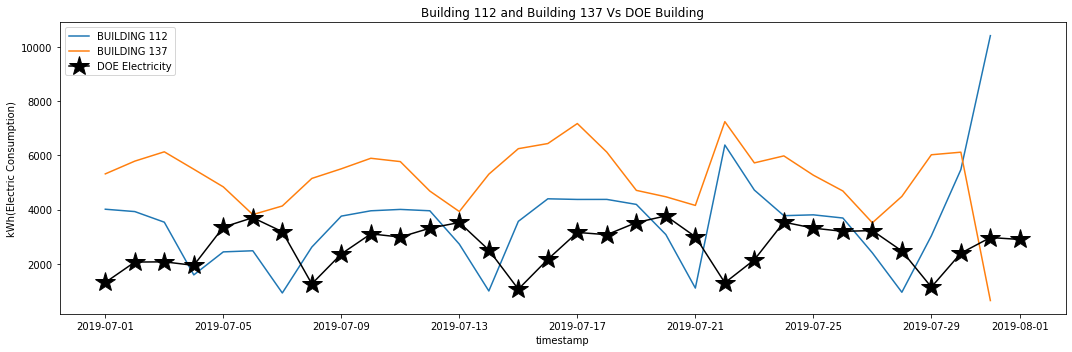

In [114]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(sensor_data5[sensor_data5.columns[0]])
plt.plot(sensor_data51)
plt.plot(ele2[181:213]['Electricity:Facility [J](TimeStep)'],marker='*',color='black',markersize=20)
plt.xlabel('timestamp')
plt.ylabel('kWh(Electric Consumption)')
plt.legend(['BUILDING 112','BUILDING 137','DOE Electricity'])
plt.title('Building 112 and Building 137 Vs DOE Building')
plt.tight_layout()
plt.show()

In [85]:
sensor_data51

197985
MultiFamily                         
2019-07-01 00:00:00+00:00  67.307848
2019-07-02 00:00:00+00:00  60.282500
2019-07-03 00:00:00+00:00  63.857500
2019-07-04 00:00:00+00:00  57.166250
2019-07-05 00:00:00+00:00  50.401250
2019-07-06 00:00:00+00:00  39.770000
2019-07-07 00:00:00+00:00  43.076250
2019-07-08 00:00:00+00:00  53.642500
2019-07-09 00:00:00+00:00  57.340000
2019-07-10 00:00:00+00:00  61.378750
2019-07-11 00:00:00+00:00  60.102500
2019-07-12 00:00:00+00:00  48.793750
2019-07-13 00:00:00+00:00  40.940000
2019-07-14 00:00:00+00:00  55.271250
2019-07-15 00:00:00+00:00  65.061250
2019-07-16 00:00:00+00:00  67.030000
2019-07-17 00:00:00+00:00  74.707500
2019-07-18 00:00:00+00:00  63.727500
2019-07-19 00:00:00+00:00  49.065000
2019-07-20 00:00:00+00:00  46.605000
2019-07-21 00:00:00+00:00  43.285000
2019-07-22 00:00:00+00:00  75.431250
2019-07-23 00:00:00+00:00  59.610000
2019-07-24 00:00:00+00:00  62.290000
2019-07-25 00:00:00+00:00  54.886250
2019-07-26 00:00:00+00:00  48.830000
2019-07-27 00:00:00+00:00  36.627500
2019-07-28 00:00:00+00:00  46.748750
2019-07-29 00:00:00+00:00  62.726250
2019-07-30 00:00:00+00:00  63.713750
2019-07-31 00:00:00+00:00  40.695000